# Intent prediction model

Model for predict the intent based on Dense NN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import os
from pathlib import Path
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, SimpleRNN, LSTM
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

/home/ramiro/bin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
pd.set_option('display.max_colwidth', -1)

## Training dataset

In [3]:
# dataset_path = 'data/snips_utterances.csv'
# intent_column = 'Intention'
# utterance = 'English'
# utterance = 'Spanish'

# print('Loading Dataset', dataset_path)
# all_intents_df = pd.read_csv(dataset_path)

In [4]:
company_name = 'origenes'
corpus_status = 'tagged'
intent_column = 'intent'
utterance = 'client_said_cleaned'

In [5]:
all_intents_df = pd.read_pickle(os.path.join('datasets', corpus_status, f'{company_name}_client_said_{corpus_status}.pkl'))

In [6]:
all_intents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12177 entries, 0 to 12176
Data columns (total 3 columns):
client_said_cleaned    12177 non-null object
intent                 12177 non-null object
confidence             12177 non-null float64
dtypes: float64(1), object(2)
memory usage: 285.5+ KB


In [7]:
all_intents_df.sample(5)[utterance]

9426     [hacer, averiguar, empleador, haciendo, aportes, mariela, celu, partir, nono, noches]                                                    
7966     [fiorella, garzon]                                                                                                                       
6926     [cuanto, cuota, cuanto, monto, gabriela, costo, cubre]                                                                                   
11222    [puedo, comunicar, telefono, antonio, sales, ahora, hs, bien, paola]                                                                     
12005    [quedaron, llamarme, aun, an, hecho, adriana, silvia, gomez, ise, ise, cel, casa, tarde, noche, dijiste, hace, robaron, debo, hacer, oka]
Name: client_said_cleaned, dtype: object

In [8]:
# Max length of the utterances
all_intents_df[utterance].str.len().max()

152

In [9]:
### Model hyperparameters
# Cutting the utterances in this length
max_len = 152

# Over the 'max_words' most frequent words.
max_words = 10000

# Dimensions of the selected Embedding
# embedding_dim = 100
embedding_dim = 300

In [10]:
print('Checking balancing of classes')
all_intents_df[intent_column].value_counts()

Checking balancing of classes


seguro vida                  2545
cotizar poliza               1917
robo celular                 1615
solicitud informacion        1476
renta vitalicia              1177
recibo pension               745 
seguro retiro                615 
certificado supervivencia    572 
fe vida                      448 
dar baja                     402 
necesito imprimir            368 
contratar seguro             180 
baja seguro                  117 
Name: intent, dtype: int64

In [11]:
# Filter by confidence factor
# all_intents_df[(all_intents_df['%cluster'] >= 0.5)].count(axis=0)

In [12]:
print('Shuffling the dataset (intents come ordered)')
all_intents_df = shuffle(all_intents_df)

Shuffling the dataset (intents come ordered)


In [13]:
print('Random sentence')
all_intents_df.sample(1)

Random sentence


,client_said_cleaned,intent,confidence
5115,"[maria, concepcion, email, hs, llego, certificado, supervivencia, cobrando, viva, recibieron, certificado, supervivencia, llamado, contestan, recibos, diciembre, enero, voy, poder, cobrar]",certificado supervivencia,1.0


In [14]:
print(f'Converting dataframe columns "{utterance}" and "{intent_column}" into lists')
sentences_list = all_intents_df[utterance].tolist()
intents_list = all_intents_df[intent_column].tolist()

Converting dataframe columns "client_said_cleaned" and "intent" into lists


In [15]:
print('Checking the size of the lists', (len(sentences_list), len(intents_list)))

Checking the size of the lists (12177, 12177)


## Tokenization and padding of data

In [16]:
def fit_tokenizer(sentences_list, max_words=10000, test_word='book'):
    """
        Fit a Keras Tokenizer based on sentences_list
    """
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(sentences_list)
    
    # Internal word_index of the tokenizer
    word_index = tokenizer.word_index
    
    print('Vocabulary of the corpora', len(word_index))
    print(f'Index of the word {test_word}', word_index[test_word])
    
    # TODO Save this tokenizer for predictions
    with open(os.path.join('dist', 'models', f'tokenizer_{company_name}.pickle'), 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Tokenizer saved')
    
    return tokenizer

In [17]:
tokenizer = fit_tokenizer(sentences_list, max_words, 'seguro')

Vocabulary of the corpora 8851
Index of the word seguro 1
Tokenizer saved


In [18]:
def vectorize_and_pad_sequences(sentences_list, tokenizer):
    print('Converting {} sentences into indices with given tokenizer'.format(len(sentences_list)))
    sequences = tokenizer.texts_to_sequences(sentences_list)
    print('Checking indices of first word', sequences[0][:10])
    
    # Transforms the sequences into 2D tensors of shape (sample, maxlen)
    # Padding to the right data[0, :]
    data = pad_sequences(sequences, maxlen=max_len)
    print('Shape of padded sequences', data.shape)
    
    return data

In [19]:
data = vectorize_and_pad_sequences(sentences_list, tokenizer)

Converting 12177 sentences into indices with given tokenizer
Checking indices of first word [1, 260, 417, 7, 10, 43, 2993, 1054]
Shape of padded sequences (12177, 152)


## Encoding and one hot of targets

In [20]:
def fit_encoder(intents_list):
    """
        Fit a Sklearn LabelEncoder based on intents_list
    """    
    encoder = LabelEncoder()
    print('Fitting a LabelEncoder with given target')
    encoder.fit(intents_list)    
    
    print('Found classes', encoder.classes_)
    print('Testing encoder', encoder.transform(encoder.classes_))
    
    np.save(os.path.join('dist', 'models', f'classes_{company_name}.npy'), encoder.classes_)
    print('Encoder saved')
    return encoder

In [21]:
encoder = fit_encoder(intents_list)

Fitting a LabelEncoder with given target
Found classes ['baja seguro' 'certificado supervivencia' 'contratar seguro'
 'cotizar poliza' 'dar baja' 'fe vida' 'necesito imprimir'
 'recibo pension' 'renta vitalicia' 'robo celular' 'seguro retiro'
 'seguro vida' 'solicitud informacion']
Testing encoder [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Encoder saved


In [22]:
def encode_and_one_hot_target(intents_list, encoder):
    print('Encoding target with given encoder')
    intents_encoded = encoder.transform(intents_list)

    print('Convert encoded classes integers to dummy variables')
    intents_one_hot = to_categorical(intents_encoded)
    
    print('Target final shape', intents_one_hot.shape)
    return intents_one_hot

In [23]:
intents_one_hot = encode_and_one_hot_target(intents_list, encoder)

Encoding target with given encoder
Convert encoded classes integers to dummy variables
Target final shape (12177, 13)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, intents_one_hot, random_state=1, test_size = .33)

In [25]:
X_train.shape, X_test.shape

((8158, 152), (4019, 152))

In [26]:
y_train.shape, y_test.shape

((8158, 13), (4019, 13))

## Embedding initialization

In [27]:
# cc.es.300.vec
def get_embedding(dim_size = 100, test_word='book'):
    """
        Builds a dictionary {'token': [embedding vector]}
        :dim_size: Could be 50, 100, 200, 300
    """
    # embedding_file_name = f'glove.6B.{dim_size}d.txt'
    # embedding_file_name = f'cc.es.{dim_size}.vec'
    embedding_file_name = f'glove-sbwc.i25.vec'
    embedding_path = os.path.join(os.getcwd(), 'embeddings', embedding_file_name)
    print('Will load the following embedding', embedding_file_name)
    embeddings_index = {}
    with open(os.path.join(os.getcwd(), 'embeddings', embedding_file_name)) as embedding_file:
        for embedding_line in embedding_file.readlines():
            token = embedding_line.split()[0]
            vector = np.asarray(embedding_line.split()[1:], dtype='float32') # Toda su representacion como Embedding
            embeddings_index[token] = vector
    
    print('Found {} word vectors.'.format(len(embeddings_index)))
    print('Checking shape', embeddings_index[test_word].shape)
    # print('Checking vector', embeddings_index['sandberger'][:100])
    
    return embeddings_index

In [28]:
# %%time
# First version
# Construye un diccionario {'token': [embedding values]}
# embeddings_index = {}
# f = open(embedding_path)
# for line in f:
#     values = line.split()
#     word = values[0] # Es el token
#     coefs = np.asarray(values[1:], dtype='float32') # Toda su representacion como Embedding
#     embeddings_index[word] = coefs
# f.close()

In [29]:
%%time
embeddings_index = get_embedding(dim_size = embedding_dim, test_word = 'libro')

Will load the following embedding glove-sbwc.i25.vec
Found 855381 word vectors.
Checking shape (300,)
CPU times: user 1min 17s, sys: 2.15 s, total: 1min 20s
Wall time: 1min 20s


In [30]:
def build_embedding_matrix(max_words, tokenizer):
    # Building the matrix for feed the embedding, has to be of shape (max_words, embedding_dim)
    embedding_matrix = np.zeros((max_words, embedding_dim))
    print('Initalizing zeros matrix of shape', embedding_matrix.shape)
    
    # tokenizer.word_index, el diccionario que definimos antes en el tokenizador con (token, indice)
    for word, i in tokenizer.word_index.items():
        # Para no pasarnos del indice 10.000
        if i < max_words:
            # Buscamos la palabra en el embedding index
            embedding_vector = embeddings_index.get(word)
            # Las palabras que no encontramos en el embedding van a ser todos cero
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    
    print('Checking representation of word 123', embedding_matrix[123][:100])
    return embedding_matrix

In [31]:
embedding_matrix = build_embedding_matrix(max_words, tokenizer)

Initalizing zeros matrix of shape (10000, 300)
Checking representation of word 123 [ 0.013983    0.015656   -0.125512    0.49004     0.334685    0.39254099
 -0.15981799 -0.118372   -0.233236    0.051459   -0.231475    0.511895
  0.471035   -0.379711   -0.521577    0.56374198 -0.14150999 -0.30565199
  0.112039   -0.27868399 -0.193812    0.034193   -0.205626    0.67226899
  0.098167    0.050468    0.098594    0.51458299 -0.161604    0.46579599
 -0.43404999  0.215607   -0.104243    0.21912301  0.57498902 -0.194419
 -0.552701    0.106965   -0.197309   -0.32554901  0.54568702  0.379031
 -0.076577    0.364501    0.39564401 -0.243542   -0.228911   -0.066483
  0.102764    0.51625198  0.33750501 -0.17247701  0.035878    0.001893
  0.239755    0.019371   -0.027835   -0.412148    0.067693   -0.00636
 -0.094935   -0.17882399 -0.46363801  0.127313    0.53180897  0.193661
 -0.002463    0.92552799  0.074762   -0.117839   -0.74339598  0.46879199
 -0.021947    0.30310199  0.17219099  0.398177    0.5000

## Model

In [32]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(13, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 152, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 45600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1459232   
_________________________________________________________________
dense_2 (Dense)              (None, 13)                429       
Total params: 4,459,661
Trainable params: 4,459,661
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Conocimiento de la capa, cada fila es la palabra con el indice i
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [34]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 152, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 45600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1459232   
_________________________________________________________________
dense_2 (Dense)              (None, 13)                429       
Total params: 4,459,661
Trainable params: 1,459,661
Non-trainable params: 3,000,000
_________________________________________________________________


In [36]:
%%time
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 6526 samples, validate on 1632 samples
Epoch 1/10
6526/6526 [==============================] - 6s 958us/step - loss: 1.4757 - acc: 0.5469 - val_loss: 1.0348 - val_acc: 0.7065
Epoch 2/10
6526/6526 [==============================] - 6s 910us/step - loss: 0.4868 - acc: 0.8586 - val_loss: 0.9217 - val_acc: 0.7298
Epoch 3/10
6526/6526 [==============================] - 6s 937us/step - loss: 0.2291 - acc: 0.9358 - val_loss: 0.9772 - val_acc: 0.7157
Epoch 4/10
6526/6526 [==============================] - 7s 999us/step - loss: 0.1201 - acc: 0.9723 - val_loss: 1.0689 - val_acc: 0.7255
Epoch 5/10
6526/6526 [==============================] - 7s 1ms/step - loss: 0.0664 - acc: 0.9871 - val_loss: 1.1887 - val_acc: 0.7200
Epoch 6/10
6526/6526 [==============================] - 6s 983us/step - loss: 0.0383 - acc: 0.9926 - val_loss: 1.3277 - val_acc: 0.7163
Epoch 7/10
6526/6526 [==============================] - 6s 996us/step - loss: 0.0228 - acc: 0.9957 - val_loss: 1.4570 - val_acc: 0.7132
Ep

In [37]:
# Serialize model to JSON
model_json = model.to_json()
with open(os.path.join('dist', 'models', f'model_{company_name}.json'), "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights(os.path.join('dist', 'models', f'model_{company_name}.h5'))
print("Saved model to disk")

Saved model to disk


## Performance

In [38]:
def print_figure(training_values, validation_values, metric):
    # Usamos un range para generar una serie entera
    epochs = range(1, len(training_values) + 1)
    
    plt.clf()
    plt.plot(epochs, training_values, 'bo', label='Training ' + metric) # bo es blue dot
    plt.plot(epochs, validation_values, 'b', label='Validation ' + metric)
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

    plt.show()    

In [39]:
def print_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    
    print_figure(loss_values, val_loss_values, 'Loss')

In [40]:
def print_acc(history):
    history_dict = history.history
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    
    print_figure(acc_values, val_acc_values, 'Accuracy')

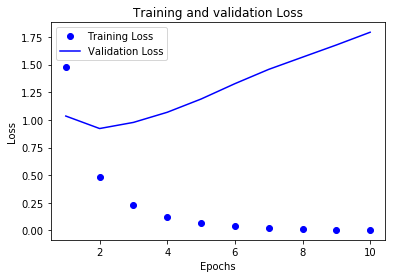

In [41]:
print_loss(history)

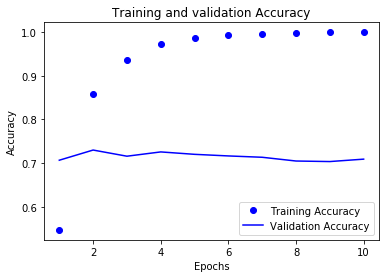

In [42]:
print_acc(history)

In [43]:
# test_loss, test_acc
results = model.evaluate(X_test, y_test)
results

4019/4019 [==============================] - 1s 227us/step


[1.890205738941334, 0.712863896417511]